In [197]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

maxDSnumbers = 3000
sizeFixed = (48,48)
dsImages = "/home/chtseng/train-opencvCascade/heads"
epoch = 20
batchSize = 32
testPath = "/home/chtseng/train-opencvCascade/keras/datasets/head_test"

In [198]:
import os
from keras.models import Sequential # Initialise our neural network model as a sequential network
from keras.layers import Conv2D # Convolution operation
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector.
from keras.layers import Dense # Perform the full connection of the neural network
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers

In [199]:
def cnn_classifier():
    cnn = Sequential()
    cnn.add(Conv2D(16, (3,3), input_shape = (sizeFixed[0], sizeFixed[1], 3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Conv2D(32, (3,3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(250, activation = 'relu'))
    cnn.add(Dense(output_dim = 2, activation = 'softmax'))

    cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    print(cnn.summary())
    return cnn

def reshaped_image(image):
    return transform.resize(image,(sizeFixed[0], sizeFixed[1], 3)) # (cols (width), rows (height)) and don't use np.resize()
   
def load_images_from_folder(dbFolder):
    train_images = []
    train_labels = []
    l = [0,0] # [False,True]
    
    Images = os.listdir(dbFolder + "/pos-images/") 
    
    i = 0
    for image in Images:
        if(i<maxDSnumbers):
            path = os.path.join(dbFolder + "/pos-images/", image)
            img = cv2.imread(path)
            train_images.append(reshaped_image(img))
            l = [1,0] 
            train_labels.append(l)
            i += 1

    i = 0
    Images = os.listdir(dbFolder + "/neg-images/")    
    for image in Images:
        if(i<maxDSnumbers):
            path = os.path.join(dbFolder + "/neg-images/", image)
            img = cv2.imread(path)
            train_images.append(reshaped_image(img))
            l = [0,1]
            train_labels.append(l)
            i += 1
        
    return np.array(train_images), np.array(train_labels)
        
def train_test_split(train_data, train_labels, fraction):
    index = int(len(train_data)*fraction)
    return train_data[:index], train_labels[:index], train_data[index:], train_labels[index:]

train_data, train_labels = load_images_from_folder(dsImages)
train_data = train_data.astype('float32') / 255.0

fraction = 0.8
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

cnn = cnn_classifier()

print ("Train data shape: ", train_data.shape)
print ("Test data shape: ", test_data.shape)

idx = np.random.permutation(train_data.shape[0])
cnn.fit(train_data[idx], train_labels[idx], batch_size = batchSize, epochs = epoch)

test_data = test_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)

print ("Actual test labels:", test_labels)
print ("Predicted test labels:", predicted_test_labels)

print ("Accuracy score:", accuracy_score(test_labels, predicted_test_labels))

Train data size:  4800
Test data size:  1200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 250)               1152250   
_________________________________________________________________
dense_56 (Dense)             (N

In [200]:
# serialize model to JSON
model_json = cnn.to_json()
with open("head_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("head_model.h5")
print("Saved model to disk")

Saved model to disk


In [201]:
from keras.models import model_from_json

# load json and create model
json_file = open('./head_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./head_model.h5",by_name=True)
print("Loaded model from disk")
 

Loaded model from disk


(1, 48, 48, 3)
0


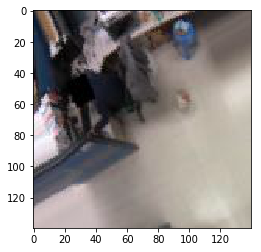

In [204]:
# evaluate loaded model on test data
loaded_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

test_image = []
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/pos-images/526-2.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_3202.jpg")
img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_2107.jpg")
plt.imshow(img)
test_image.append(reshaped_image(img))
test_image = np.array(test_image)
print(test_image.shape)

test_image = test_image.astype('float32') / 255.0
#result = loaded_model.predict(test_image)
img_class = loaded_model.predict_classes(test_image)
prediction = img_class[0]
print(prediction)
#print( np.argmax(result, axis=1) )

In [193]:
dsRetrain = "/home/chtseng/train-opencvCascade/keras/head_retrain"

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=180,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

#Retrain
train_data, train_labels = load_images_from_folder(dsRetrain)
train_data = train_data.astype('float32') / 255.0

fraction = 0.9
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

idx = np.random.permutation(train_data.shape[0])
#loaded_model.fit(train_data[idx], train_labels[idx], batch_size = batchSize, epochs = epoch)
datagen.fit(train_data)

loaded_model.fit_generator(datagen.flow(train_data,train_labels, batch_size=32),
    steps_per_epoch=round(len(train_data)/32),epochs=60, validation_data=(test_data, test_labels))

            

test_data = test_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)

print ("Actual test labels:", test_labels)
print ("Predicted test labels:", predicted_test_labels)

print ("Accuracy score:", accuracy_score(test_labels, predicted_test_labels))

Train data size:  27
Test data size:  4
Epoch 1/60
1/1 [==============================] - 0s 161ms/step - loss: 0.4548 - acc: 0.7778 - val_loss: 1.0502 - val_acc: 0.5000
Epoch 2/60
1/1 [==============================] - 0s 203ms/step - loss: 0.4680 - acc: 0.7407 - val_loss: 1.0341 - val_acc: 0.5000
Epoch 3/60
1/1 [==============================] - 0s 196ms/step - loss: 0.4508 - acc: 0.7778 - val_loss: 1.0131 - val_acc: 0.5000
Epoch 4/60
1/1 [==============================] - 0s 199ms/step - loss: 0.4225 - acc: 0.7778 - val_loss: 0.9907 - val_acc: 0.5000
Epoch 5/60
1/1 [==============================] - 0s 203ms/step - loss: 0.4514 - acc: 0.7778 - val_loss: 0.9675 - val_acc: 0.5000
Epoch 6/60
1/1 [==============================] - 0s 197ms/step - loss: 0.4122 - acc: 0.7778 - val_loss: 0.9440 - val_acc: 0.5000
Epoch 7/60
1/1 [==============================] - 0s 196ms/step - loss: 0.4124 - acc: 0.7778 - val_loss: 0.9182 - val_acc: 0.5000
Epoch 8/60
1/1 [==============================] - 

(1, 48, 48, 3)
0


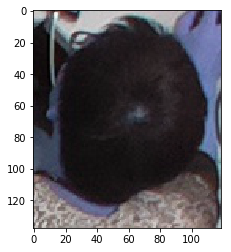

In [196]:
test_image = []
img = cv2.imread("/home/chtseng/train-opencvCascade/heads/pos-images/526-2.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_3202.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_2107.jpg")
plt.imshow(img)
test_image.append(reshaped_image(img))
test_image = np.array(test_image)
print(test_image.shape)

test_image = test_image.astype('float32') / 255.0
#result = loaded_model.predict(test_image)
img_class = loaded_model.predict_classes(test_image)
prediction = img_class[0]
print(prediction)

In [180]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("head_model_retrain.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("head_model_retrain.h5")
print("Saved model to disk")

Saved model to disk
